# Part 2 - Categorically Speaking

### Reestablish Baseline

In [1]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score
import numpy as np
import pandas as pd
from rfpimp import *

In [2]:
def evaluate(X, y):
    rf = RandomForestRegressor(n_estimators=100, n_jobs=-1, oob_score=True)
    rf.fit(X, y)
    oob = rf.oob_score_
    n = rfnnodes(rf)
    h = np.median(rfmaxdepths(rf))
    print(f"OOB R^2 is {oob:.5f} using {n:,d} tree nodes with {h} median tree depth")
    return rf, oob

In [3]:
def showimp(rf, X, y):
    features = list(X.columns)
    features.remove('latitude')
    features.remove('longitude')
    features += [['latitude','longitude']]

    I = importances(rf, X, y, features=features)
    plot_importances(I, color='#4575b4')

In [4]:
rent = pd.read_csv('rent.csv')

rent_clean = rent[(rent['price'] > 1000) & (rent['price'] < 10000)]
rent_clean = rent_clean[(rent_clean['longitude'] !=0) | (rent_clean['latitude']!=0)]
rent_clean = rent_clean[(rent_clean['latitude']>40.55) &
                        (rent_clean['latitude']<40.94) &
                        (rent_clean['longitude']>-74.1) &
                        (rent_clean['longitude']<-73.67)]

In [5]:
numfeatures = ['bathrooms', 'bedrooms', 'longitude', 'latitude']

X = rent_clean[numfeatures]
y = rent_clean['price']

rf, oob = evaluate(X, y)

OOB R^2 is 0.86782 using 2,433,480 tree nodes with 35.0 median tree depth


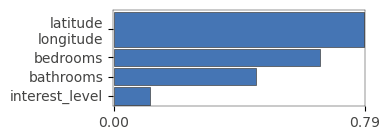

In [22]:
showimp(rf, X, y)

### Categorical Variables

Recall that categorical variables tend to come in two kinds:
- Ordinal
    - where there is some natural ordering to the categories
- Nominal
    - where there is no natural ordering to the categories

### What Have We Ignored So Far?

Our baseline model used the numeric features `bathrooms`, `bedrooms`, `longtitude`, and `latitutde`, but we know that our data has other features. We would now like to see if these features contain any information that our model can use; that is, to help the model better understand the relationship between the features and the target so as to improve its ability to make accurate predictions. 

Let's first look at the remaining features. 

In [7]:
non_num = [col for col in rent_clean.columns.tolist() if col not in numfeatures + ['price']]
non_num

['building_id',
 'created',
 'description',
 'display_address',
 'features',
 'listing_id',
 'manager_id',
 'photos',
 'street_address',
 'interest_level']

In [8]:
rent_nonnum = rent_clean[non_num]
rent_nonnum.head().T

,0,1,2,3,4
building_id,8579a0b0d54db803821a35a4a615e97a,b8e75fc949a6cd8225b455648a951712,cd759a988b8f23924b5a2058d5ab2b49,53a5b119ba8f7b61d4e010512e0dfc85,bfb9405149bfff42a92980b594c28234
created,2016-06-16 05:55:27,2016-06-01 05:44:33,2016-06-14 15:19:59,2016-06-24 07:54:24,2016-06-28 03:50:23
description,Spacious 1 Bedroom 1 Bathroom in Williamsburg!...,BRAND NEW GUT RENOVATED TRUE 2 BEDROOMFind you...,**FLEX 2 BEDROOM WITH FULL PRESSURIZED WALL**L...,A Brand New 3 Bedroom 1.5 bath ApartmentEnjoy ...,Over-sized Studio w abundant closets. Availabl...
display_address,145 Borinquen Place,East 44th,East 56th Street,Metropolitan Avenue,East 34th Street
features,"['Dining Room', 'Pre-War', 'Laundry in Buildin...","['Doorman', 'Elevator', 'Laundry in Building',...","['Doorman', 'Elevator', 'Laundry in Building',...",[],"['Doorman', 'Elevator', 'Fitness Center', 'Lau..."
listing_id,7170325,7092344,7158677,7211212,7225292
manager_id,a10db4590843d78c784171a107bdacb4,955db33477af4f40004820b4aed804a0,c8b10a317b766204f08e613cef4ce7a0,5ba989232d0489da1b5f2c45f6688adc,2c3b41f588fbb5234d8a1e885a436cfa
photos,['https://photos.renthop.com/2/7170325_3bb5ac8...,['https://photos.renthop.com/2/7092344_7663c19...,['https://photos.renthop.com/2/7158677_c897a13...,['https://photos.renthop.com/2/7211212_1ed4542...,['https://photos.renthop.com/2/7225292_901f198...
street_address,145 Borinquen Place,230 East 44th,405 East 56th Street,792 Metropolitan Avenue,340 East 34th Street
interest_level,medium,low,medium,medium,low


In [9]:
rent_nonnum.shape

(48300, 10)

In [10]:
rent_nonnum.nunique(dropna=False)

building_id         7417
created            47643
description        37491
display_address     8692
features            9924
listing_id         48300
manager_id          3409
photos             44703
street_address     15094
interest_level         3
dtype: int64

In [11]:
pip install category_encoders

Note: you may need to restart the kernel to use updated packages.


In [12]:
rent_nonnum['interest_level'].unique()

array(['medium', 'low', 'high'], dtype=object)

In [17]:
X = rent_clean[numfeatures + ['interest_level']]
X.head()

,bathrooms,bedrooms,longitude,latitude,interest_level
0,1.0,1,-73.9539,40.7108,medium
1,1.0,2,-73.9722,40.7513,low
2,1.0,2,-73.9625,40.7575,medium
3,1.5,3,-73.9425,40.7145,medium
4,1.0,0,-73.9743,40.7439,low


In [20]:
import category_encoders as ce

encoder = ce.OrdinalEncoder(mapping = [{'col':'interest_level','mapping':{'low' : 1 , 'medium' :2, 'high':3}}])
encoder.fit(X)
X = encoder.transform(X)

X.head()

,bathrooms,bedrooms,longitude,latitude,interest_level
0,1.0,1,-73.9539,40.7108,2
1,1.0,2,-73.9722,40.7513,1
2,1.0,2,-73.9625,40.7575,2
3,1.5,3,-73.9425,40.7145,2
4,1.0,0,-73.9743,40.7439,1


In [21]:
rf, oob = evaluate(X, y)

OOB R^2 is 0.87088 using 3,023,512 tree nodes with 35.0 median tree depth


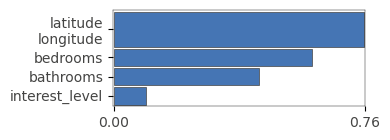

In [23]:
showimp(rf, X, y)

In [24]:
rent_nonnum['manager_id'].unique()

array(['a10db4590843d78c784171a107bdacb4',
       '955db33477af4f40004820b4aed804a0',
       'c8b10a317b766204f08e613cef4ce7a0', ...,
       'bf077b3e472557cb660271eafe1629aa',
       '78a2411ba7621e3a54d8f325e44b92f4',
       'cda0d536fb182dfed7cc48f0884d3203'], dtype=object)

In [29]:
X = rent_clean[numfeatures + ['manager_id']]
X.head()

,bathrooms,bedrooms,longitude,latitude,manager_id
0,1.0,1,-73.9539,40.7108,a10db4590843d78c784171a107bdacb4
1,1.0,2,-73.9722,40.7513,955db33477af4f40004820b4aed804a0
2,1.0,2,-73.9625,40.7575,c8b10a317b766204f08e613cef4ce7a0
3,1.5,3,-73.9425,40.7145,5ba989232d0489da1b5f2c45f6688adc
4,1.0,0,-73.9743,40.7439,2c3b41f588fbb5234d8a1e885a436cfa


In [26]:
encoder = ce.OrdinalEncoder(cols=['manager_id'])
encoder.fit(X)
X = encoder.transform(X)

X.head()

,bathrooms,bedrooms,longitude,latitude,manager_id
0,1.0,1,-73.9539,40.7108,1
1,1.0,2,-73.9722,40.7513,2
2,1.0,2,-73.9625,40.7575,3
3,1.5,3,-73.9425,40.7145,4
4,1.0,0,-73.9743,40.7439,5


In [27]:
rf, oob = evaluate(X, y)

OOB R^2 is 0.86109 using 4,600,616 tree nodes with 40.0 median tree depth


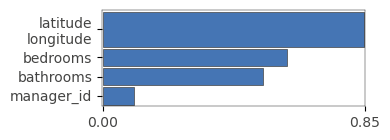

In [28]:
showimp(rf, X, y)

In [29]:
X = rent_clean[numfeatures + ['manager_id']]
X.head()

,bathrooms,bedrooms,longitude,latitude,manager_id
0,1.0,1,-73.9539,40.7108,a10db4590843d78c784171a107bdacb4
1,1.0,2,-73.9722,40.7513,955db33477af4f40004820b4aed804a0
2,1.0,2,-73.9625,40.7575,c8b10a317b766204f08e613cef4ce7a0
3,1.5,3,-73.9425,40.7145,5ba989232d0489da1b5f2c45f6688adc
4,1.0,0,-73.9743,40.7439,2c3b41f588fbb5234d8a1e885a436cfa


In [30]:
encoder = ce.CountEncoder(cols=['manager_id'])
encoder.fit(X)
X = encoder.transform(X)

X.head()

,bathrooms,bedrooms,longitude,latitude,manager_id
0,1.0,1,-73.9539,40.7108,112
1,1.0,2,-73.9722,40.7513,26
2,1.0,2,-73.9625,40.7575,93
3,1.5,3,-73.9425,40.7145,90
4,1.0,0,-73.9743,40.7439,54


In [31]:
rf, oob = evaluate(X, y)

OOB R^2 is 0.86385 using 4,535,918 tree nodes with 40.0 median tree depth


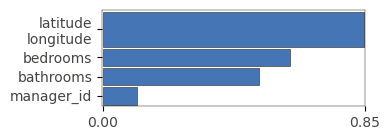

In [32]:
showimp(rf, X, y)

In [33]:
X = rent_clean[numfeatures + ['manager_id']]
X.head()

,bathrooms,bedrooms,longitude,latitude,manager_id
0,1.0,1,-73.9539,40.7108,a10db4590843d78c784171a107bdacb4
1,1.0,2,-73.9722,40.7513,955db33477af4f40004820b4aed804a0
2,1.0,2,-73.9625,40.7575,c8b10a317b766204f08e613cef4ce7a0
3,1.5,3,-73.9425,40.7145,5ba989232d0489da1b5f2c45f6688adc
4,1.0,0,-73.9743,40.7439,2c3b41f588fbb5234d8a1e885a436cfa


In [35]:
encoder = ce.OneHotEncoder(cols=['manager_id'])
encoder.fit(X)
X = encoder.transform(X)

X.head()

,bathrooms,bedrooms,longitude,latitude,manager_id_1,manager_id_2,manager_id_3,manager_id_4,manager_id_5,manager_id_6,...,manager_id_3400,manager_id_3401,manager_id_3402,manager_id_3403,manager_id_3404,manager_id_3405,manager_id_3406,manager_id_3407,manager_id_3408,manager_id_3409
0,1.0,1,-73.9539,40.7108,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1.0,2,-73.9722,40.7513,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1.0,2,-73.9625,40.7575,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1.5,3,-73.9425,40.7145,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1.0,0,-73.9743,40.7439,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [36]:
rf, oob = evaluate(X, y)

OOB R^2 is 0.86115 using 4,310,844 tree nodes with 97.5 median tree depth


In [37]:
rent_nonnum.nunique(dropna=False)

building_id         7417
created            47643
description        37491
display_address     8692
features            9924
listing_id         48300
manager_id          3409
photos             44703
street_address     15094
interest_level         3
dtype: int64

In [43]:
rent_text = rent_clean[['description','features','photos']].copy()
rent_text.head()

,description,features,photos
0,Spacious 1 Bedroom 1 Bathroom in Williamsburg!...,"['Dining Room', 'Pre-War', 'Laundry in Buildin...",['https://photos.renthop.com/2/7170325_3bb5ac8...
1,BRAND NEW GUT RENOVATED TRUE 2 BEDROOMFind you...,"['Doorman', 'Elevator', 'Laundry in Building',...",['https://photos.renthop.com/2/7092344_7663c19...
2,**FLEX 2 BEDROOM WITH FULL PRESSURIZED WALL**L...,"['Doorman', 'Elevator', 'Laundry in Building',...",['https://photos.renthop.com/2/7158677_c897a13...
3,A Brand New 3 Bedroom 1.5 bath ApartmentEnjoy ...,[],['https://photos.renthop.com/2/7211212_1ed4542...
4,Over-sized Studio w abundant closets. Availabl...,"['Doorman', 'Elevator', 'Fitness Center', 'Lau...",['https://photos.renthop.com/2/7225292_901f198...


In [44]:
rent_text.isnull().sum()

description    1421
features          0
photos            0
dtype: int64

In [48]:
rent_clean['description'] =  rent_clean['description'].fillna('')
rent_clean['description'] =  rent_clean['description'].str.lower()
rent_clean['description'].head(50)

0     spacious 1 bedroom 1 bathroom in williamsburg!...
1     brand new gut renovated true 2 bedroomfind you...
2     **flex 2 bedroom with full pressurized wall**l...
3     a brand new 3 bedroom 1.5 bath apartmentenjoy ...
4     over-sized studio w abundant closets. availabl...
5     this spectacular converted 3 bed apartment all...
6     amazing deal!! brand new renovations in this h...
7     no fee large renovated sun splashed studio. wa...
8     extra large one bedroom apartment located in p...
9             listed: 06/26/16<br /><br />available:...
10    location: upper east sideamazing studio with h...
11    no fee!! this luxurious building offers apartm...
12    this is a luxurious jr 1 bedroom with tons of ...
13    this large 1 bedroom is located in the heart o...
14    renovated 3 bedroom/2 bath with open-concept k...
15    bright &  large studio  apartment + outdoor sp...
16    this is a great deal for a spacious, bright ap...
17    no broker's fee!!! all utilities free: hea

In [49]:
rent_clean['renov'] =  rent_clean['description'].str.contains("renov")
rent_clean['new'] =  rent_clean['description'].str.contains("new")
rent_clean.head().T

,0,1,2,3,4
bathrooms,1.0,1.0,1.0,1.5,1.0
bedrooms,1,2,2,3,0
building_id,8579a0b0d54db803821a35a4a615e97a,b8e75fc949a6cd8225b455648a951712,cd759a988b8f23924b5a2058d5ab2b49,53a5b119ba8f7b61d4e010512e0dfc85,bfb9405149bfff42a92980b594c28234
created,2016-06-16 05:55:27,2016-06-01 05:44:33,2016-06-14 15:19:59,2016-06-24 07:54:24,2016-06-28 03:50:23
description,spacious 1 bedroom 1 bathroom in williamsburg!...,brand new gut renovated true 2 bedroomfind you...,**flex 2 bedroom with full pressurized wall**l...,a brand new 3 bedroom 1.5 bath apartmentenjoy ...,over-sized studio w abundant closets. availabl...
display_address,145 Borinquen Place,East 44th,East 56th Street,Metropolitan Avenue,East 34th Street
features,"['Dining Room', 'Pre-War', 'Laundry in Buildin...","['Doorman', 'Elevator', 'Laundry in Building',...","['Doorman', 'Elevator', 'Laundry in Building',...",[],"['Doorman', 'Elevator', 'Fitness Center', 'Lau..."
latitude,40.7108,40.7513,40.7575,40.7145,40.7439
listing_id,7170325,7092344,7158677,7211212,7225292
longitude,-73.9539,-73.9722,-73.9625,-73.9425,-73.9743


In [50]:
rent_clean['new'].sum()

21403

In [51]:
rent_clean['renov'].sum()

17327

In [52]:
X = rent_clean[numfeatures + ['new' , 'renov']]
X.head()

,bathrooms,bedrooms,longitude,latitude,new,renov
0,1.0,1,-73.9539,40.7108,False,True
1,1.0,2,-73.9722,40.7513,True,True
2,1.0,2,-73.9625,40.7575,False,False
3,1.5,3,-73.9425,40.7145,True,False
4,1.0,0,-73.9743,40.7439,False,False


In [53]:
rf, oob = evaluate(X, y)

OOB R^2 is 0.86597 using 3,290,596 tree nodes with 36.0 median tree depth


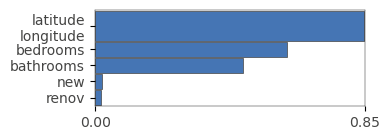

In [54]:
showimp(rf,X,y)

In [55]:
rent_clean['features'].head(50)

0     ['Dining Room', 'Pre-War', 'Laundry in Buildin...
1     ['Doorman', 'Elevator', 'Laundry in Building',...
2     ['Doorman', 'Elevator', 'Laundry in Building',...
3                                                    []
4     ['Doorman', 'Elevator', 'Fitness Center', 'Lau...
5     ['Doorman', 'Elevator', 'Loft', 'Dishwasher', ...
6     ['Fireplace', 'Laundry in Unit', 'Dishwasher',...
7     ['Elevator', 'Laundry in Building', 'Dishwashe...
8                                   ['Hardwood Floors']
9                      ['Cats Allowed', 'Dogs Allowed']
10    ['Doorman', 'Elevator', 'Laundry in Building',...
11    ['Roof Deck', 'Doorman', 'Elevator', 'Fitness ...
12    ['Swimming Pool', 'Roof Deck', 'Doorman', 'Ele...
13                                  ['Hardwood Floors']
14    ['Doorman', 'Elevator', 'Laundry in Building',...
15                                      ['Reduced Fee']
16           ['Doorman', 'Elevator', 'Hardwood Floors']
17    ['Common Outdoor Space', 'Cats Allowed', '

In [56]:
rent_clean['features'] =  rent_clean['features'].str.lower()
rent_clean['doorman'] =  rent_clean['features'].str.contains("doorman")
rent_clean['hardwood'] =  rent_clean['features'].str.contains("hardwood")
rent_clean.head().T


,0,1,2,3,4
bathrooms,1.0,1.0,1.0,1.5,1.0
bedrooms,1,2,2,3,0
building_id,8579a0b0d54db803821a35a4a615e97a,b8e75fc949a6cd8225b455648a951712,cd759a988b8f23924b5a2058d5ab2b49,53a5b119ba8f7b61d4e010512e0dfc85,bfb9405149bfff42a92980b594c28234
created,2016-06-16 05:55:27,2016-06-01 05:44:33,2016-06-14 15:19:59,2016-06-24 07:54:24,2016-06-28 03:50:23
description,spacious 1 bedroom 1 bathroom in williamsburg!...,brand new gut renovated true 2 bedroomfind you...,**flex 2 bedroom with full pressurized wall**l...,a brand new 3 bedroom 1.5 bath apartmentenjoy ...,over-sized studio w abundant closets. availabl...
display_address,145 Borinquen Place,East 44th,East 56th Street,Metropolitan Avenue,East 34th Street
features,"['dining room', 'pre-war', 'laundry in buildin...","['doorman', 'elevator', 'laundry in building',...","['doorman', 'elevator', 'laundry in building',...",[],"['doorman', 'elevator', 'fitness center', 'lau..."
latitude,40.7108,40.7513,40.7575,40.7145,40.7439
listing_id,7170325,7092344,7158677,7211212,7225292
longitude,-73.9539,-73.9722,-73.9625,-73.9425,-73.9743


In [60]:
X = rent_clean[numfeatures + ['doorman']]
X.head()

,bathrooms,bedrooms,longitude,latitude,doorman
0,1.0,1,-73.9539,40.7108,False
1,1.0,2,-73.9722,40.7513,True
2,1.0,2,-73.9625,40.7575,True
3,1.5,3,-73.9425,40.7145,False
4,1.0,0,-73.9743,40.7439,True


In [61]:
rf, oob = evaluate(X, y)

OOB R^2 is 0.86897 using 2,554,406 tree nodes with 35.0 median tree depth


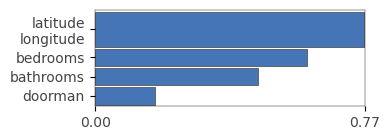

In [62]:
showimp(rf,X,y)

In [63]:
rent_clean['photos'].head(5)

0    ['https://photos.renthop.com/2/7170325_3bb5ac8...
1    ['https://photos.renthop.com/2/7092344_7663c19...
2    ['https://photos.renthop.com/2/7158677_c897a13...
3    ['https://photos.renthop.com/2/7211212_1ed4542...
4    ['https://photos.renthop.com/2/7225292_901f198...
Name: photos, dtype: object

In [65]:
rent_clean['photos'].apply(lambda x: len(x.split(",")))

0        12
1         6
2         6
3         5
4         4
         ..
49347     5
49348     5
49349     3
49350     5
49351     8
Name: photos, Length: 48300, dtype: int64

In [66]:
rent_clean['num_photos'] = rent_clean['photos'].apply(lambda x: len(x.split(",")))

In [69]:
X = rent_clean[numfeatures + ['num_photos']]
X.head()

,bathrooms,bedrooms,longitude,latitude,num_photos
0,1.0,1,-73.9539,40.7108,12
1,1.0,2,-73.9722,40.7513,6
2,1.0,2,-73.9625,40.7575,6
3,1.5,3,-73.9425,40.7145,5
4,1.0,0,-73.9743,40.7439,4


In [70]:
rf, oob = evaluate(X, y)

OOB R^2 is 0.85849 using 3,928,278 tree nodes with 38.5 median tree depth


In [71]:
rent_clean['num_features'] = rent_clean['features'].apply(lambda x: len(x.split(",")))

In [72]:
X = rent_clean[numfeatures + ['num_features']]
X.head()

,bathrooms,bedrooms,longitude,latitude,num_features
0,1.0,1,-73.9539,40.7108,7
1,1.0,2,-73.9722,40.7513,6
2,1.0,2,-73.9625,40.7575,6
3,1.5,3,-73.9425,40.7145,1
4,1.0,0,-73.9743,40.7439,4


In [73]:
rf, oob = evaluate(X, y)

OOB R^2 is 0.86048 using 3,846,484 tree nodes with 37.0 median tree depth


In [74]:
rent_clean['num_description'] = rent_clean['description'].apply(lambda x: len(x.split(" ")))

In [75]:
X = rent_clean[numfeatures + ['num_description']]
X.head()

,bathrooms,bedrooms,longitude,latitude,num_description
0,1.0,1,-73.9539,40.7108,77
1,1.0,2,-73.9722,40.7513,131
2,1.0,2,-73.9625,40.7575,119
3,1.5,3,-73.9425,40.7145,95
4,1.0,0,-73.9743,40.7439,41


In [76]:
rf, oob = evaluate(X, y)

OOB R^2 is 0.85980 using 4,711,258 tree nodes with 41.0 median tree depth
